In [6]:
import sys
sys.path.append('..')
import json
from robot import PIDRobot, load_robot_json

# Modeling a Two Wheeled Inverted Pendulum

This notebook outlines the work done in the twip sim python library. The TWIP simulator describes the dynamics, kinematics, actuators and controls of the robot. Further, it provides rudimentary structures and methods to reason about its state space. That is, simulations can be used to sample the state space and determine region attributes. 

## Model Architecture

All simulated models that the robot is composed of is inherited off of a ``SysBase`` object. Most generally, this object hold two coordinate systems, one for dynamics and another for kinematics. Also, the object supports model parameters, being values that don't necessarily evolve in time. Lastly, the ``SysBase`` declares and implements a default solver. For the continuous case, ``SysBase`` implements a stiff integrator as its solver. Supporting a stiff solver, it was discovered, was essential for correctly simulating motor dynamics.

Next, another generic system type, ``IterSysBase``, is used. It supports the definition of systems expressible as iterative maps, with discrete time systems being an example. Nearly all control systems in the scope of this project will require ``IterSysBase`` as they will operate in discrete time as a certain frequency. Simulating mixed domain permits behavior arising from discretization to be observed.

<img src="./img/twip_arch.PNG" alt="Drawing" style="width: 400px;"/>

## System Description

TWIP sim has many system parameters that need to be collected in order to simulate accurately. As such, configuration management needs to be performed in order to assess design tradeoffs. As is currently implemented, TWIP sim can store and load a complete robot description is a json file. Looking at the supplied `robot_generic.json` file, the structure resembles,

```
{
  "twip": {
    "Mw": 0.8,
        .
        .
        .
    "g": 9.81
  },
  "motor_left": {
    "J": 0.001,
        .
        .
        .
    "b": 0.0001
  },
  "motor_right": {
    "J": 0.001,
        .
        .
        .
    "b": 0.0001
  },
  "controller_tilt": {
    "type": "PID",
    "params": {
      "Kp": 75.0,
        .
        .
        .
      "type": "linear"
    }
  },
  "controller_yaw": {
    "type": "PID",
    "params": {
      "Kp": 25.0,
        .
        .
        .
      "type": "linear"
    }
  }
}
```

In [7]:
rbt = load_robot_json("robot_generic.json")
print(rbt)

--- TWIP
System Model TWIPZi
Equations: Zi et al.
Inputs: 4
Dynamics Space: 6
Kinematics Space: 5
--- Left Motor
System Model PWMDCMotor
Equations: Vukosavic
Inputs: 1
Dynamics Space: 2
Kinematics Space: 1
--- Right Motor
System Model PWMDCMotor
Equations: Vukosavic
Inputs: 1
Dynamics Space: 2
Kinematics Space: 1
--- Tilt Controller
System Model IterPID
Equations: PID
Inputs: 1
Dynamics Space: 4
Kinematics Space: 1
--- Yaw Controller
System Model IterPID
Equations: PID
Inputs: 1
Dynamics Space: 4
Kinematics Space: 1



## Model Visualization

Due to the design nature of the project, it is desirable to be able to able to visualize the parameters, and to a limited degree, interact with the design. As such, an emphasis was placed on visualization. Currently, the library relies of ``PyQt``, ``pyqtgraph`` and ``PyOpenGL`` for realtime, interactive graphics. ``PyGame`` is used to a lesser degrees to handle peripherals and produce a game loop.

<img src="./img/twip_widget.PNG" alt="Drawing" style="width: 600px;"/>

The library contains the ``TWIPWidget`` and ``RollingPlotWidget`` objects to easily create visualizations. These widgets need to be added to a QApplication to be used. 

## State Space Verification

Currently, dynamical verification is done using statistical methods. That is, certificates are generated directly by using simulations of the close loops robots. This methodology has been prefered over more analytical or symbolic approaches because it relies on the fewest simplifications of the system modeling. That is, there has been some success performing verification on some variations of the TWIP model, but it relies on assuming perfect motor dynamics as well as a continuous time controller. 

Like as sampling methods, there exists assumptions of what can be correctly reconstruted through sampling. Due to the nature of the state space, many methods exist to sample the state space in a more intelligent manor that simply using uniform random sampling or uniform tesselation. Notably, binary space partitioning can support efficient adaptive sampling. More recently, active learning using gaussian process classification is being explored. 

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm

def is_stable(twip, IC, t_max=10, inner_radius=0.18, outer_radius=1):
    dt = 1/50
    twip.set_IC(IC)
    twip.update_current_state(dt, [0, 0, 0, 0])
    t =  0
    while t < t_max:
        twip.update_current_state(dt, [0, 0, 0, 0])
        t += dt 
        cpos = twip.twip.q[1:]
        if np.linalg.norm(cpos) <= inner_radius:
            return True
        elif np.linalg.norm(cpos) >= outer_radius:
            return False
    return False
        

### Simple Random Sampling Example

In [28]:
N = 1500
X = np.random.rand(N, 3)*.5 - 0.25
X[:, 1] *= 3

In [29]:
Y = np.zeros(N, dtype=np.bool)
for i in tqdm(range(N)):
    x = X[i, :]
    Y[i] = is_stable(rbt, [0, 0, x[0], x[1], 0, x[2]])


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:19<00:00, 10.72it/s]


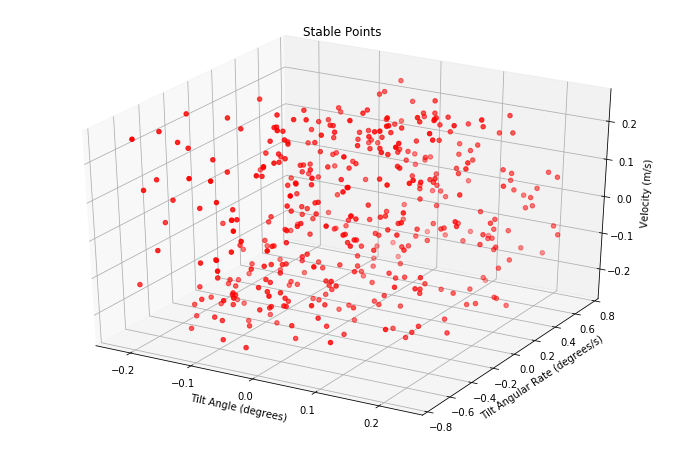

In [30]:
Xu = np.copy(X)
Xu[:, 0] = X[:, 0] * 180/np.pi
Xu[:, 1] = X[:, 1] * 180/np.pi
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X[Y == 1].T, c='r', marker='o')
ax.set_title("Stable Points")
ax.set_xlabel('Tilt Angle (degrees)')
ax.set_ylabel('Tilt Angular Rate (degrees/s)')
ax.set_zlabel('Velocity (m/s)')
plt.show()

In [8]:
N = 1000
Xn = np.random.rand(N, 2)*.5 - 0.25
Xn[:, 1] *= 3
Y = np.zeros(N, dtype=np.bool)
for i in tqdm(range(N)):
    x = Xn[i, :]
    Y[i] = is_stable(rbt, [0, 0, x[0], x[1], 0, 0])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.81it/s]


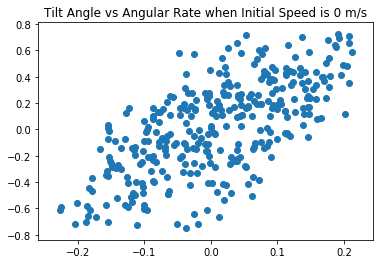

In [11]:
Xs = Xn[Y==1]
plt.figure()
plt.title("Tilt Angle vs Angular Rate when Initial Speed is 0 m/s")
plt.scatter(*Xs.T)
plt.show()

In [12]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [15]:
kernel = RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel).fit(Xn, Y)

In [16]:
h = 0.02
x_min, x_max = Xn[:, 0].min()-0.1, Xn[:, 0].max() +.1
y_min, y_max = Xn[:, 1].min()-0.1 , Xn[:, 1].max() +.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [17]:
pts = np.vstack((xx.ravel(), yy.ravel())).T
Z = gpc.predict_proba(pts)

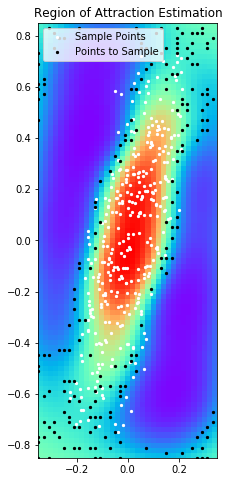

In [18]:
Z = Z.reshape((*xx.shape, 2))
mask = (Z[:, :, 1] < 0.5) & (Z[:, :, 1] > 0.2)
new_pts = pts[mask.ravel()]
np.random.shuffle(new_pts)
new_pts = new_pts[:200]
plt.figure(figsize=(12,8))
plt.scatter(*Xs.T, c='w', s=5, label='Sample Points')
plt.scatter(*new_pts.T, c='k', s=5, marker='o', label='Points to Sample')
plt.imshow(Z[:, :, 1], extent=(x_min, x_max, y_min, y_max), origin="lower", cmap='rainbow')
plt.title("Region of Attraction Estimation")
plt.legend()
plt.show()

In [43]:
Ynew = np.zeros(new_pts.shape[0], dtype=np.bool)
for i in tqdm(range(new_pts.shape[0])):
    x = new_pts[i, :]
    Y[i] = is_stable(rbt, [0, 0, x[0], x[1], 0, 0])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.12it/s]


In [44]:
Xnn = np.vstack((Xn, new_pts))
Ynn = np.hstack((Y, Ynew))
gpc = GaussianProcessClassifier(kernel=kernel).fit(Xnn, Ynn)

In [45]:
h = 0.02
x_min, x_max = Xnn[:, 0].min(), Xnn[:, 0].max()
y_min, y_max = Xnn[:, 1].min() , Xnn[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [46]:
pts = np.vstack((xx.ravel(), yy.ravel())).T
Z = gpc.predict_proba(pts)

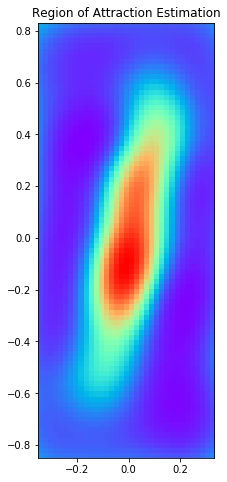

In [49]:
Z = Z.reshape((*xx.shape, 2))
plt.figure(figsize=(12,8))
plt.imshow(Z[:, :, 1], extent=(x_min, x_max, y_min, y_max), origin="lower", cmap='rainbow')
plt.title("Region of Attraction Estimation")
plt.show()